# Introdução

In [54]:
import pandas as pd
import pymc as pm
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import arviz as az

In [23]:
# Carregamento dos dados a partir de um arquivo CSV localizado no Google Drive.
original = pd.read_csv('./staging/porto_ts.csv')

In [24]:
original

,ano,mes,porto,graos,outras,sugar
0,2005,1,5027941,412400,1780376,581383
1,2005,2,5316605,707274,1821686,878016
2,2005,3,5899912,1221079,1917759,610140
3,2005,4,5850639,1301598,1976311,764285
4,2005,5,6826372,1575474,2122232,1007705
...,...,...,...,...,...,...
211,2022,8,14626790,4122517,3188229,2455597
212,2022,9,13628567,3743920,3258989,2079487
213,2022,10,14435751,4185655,3198681,2249483
214,2022,11,12194409,3459541,2558110,2199680


### Alguns ajustes para o projeto atual

In [25]:
# remoção de colunas desnecessárias
original.drop(['graos','outras','sugar'], axis=1, inplace=True)

In [26]:
original

,ano,mes,porto
0,2005,1,5027941
1,2005,2,5316605
2,2005,3,5899912
3,2005,4,5850639
4,2005,5,6826372
...,...,...,...
211,2022,8,14626790
212,2022,9,13628567
213,2022,10,14435751
214,2022,11,12194409


In [27]:
# Conversão das colunas 'ano' e 'mes' para um índice datetime.
original['data'] = pd.to_datetime(original['ano'].astype(str) + '-' + original['mes'].astype(str), format='%Y-%m')
#original['lastDay'] = original['data'] + pd.offsets.MonthBegin(0)   # set a data no início do mês
original['lastDay'] = original['data'] + pd.offsets.MonthEnd(0)    # set a data no final do mês

original['data'] = original['lastDay'].dt.strftime("%Y-%m-%d")
original.drop(['lastDay'], axis=1, inplace=True)
original['data'] = pd.to_datetime(original['data'])
print(original)

      ano  mes     porto       data
0    2005    1   5027941 2005-01-31
1    2005    2   5316605 2005-02-28
2    2005    3   5899912 2005-03-31
3    2005    4   5850639 2005-04-30
4    2005    5   6826372 2005-05-31
..    ...  ...       ...        ...
211  2022    8  14626790 2022-08-31
212  2022    9  13628567 2022-09-30
213  2022   10  14435751 2022-10-31
214  2022   11  12194409 2022-11-30
215  2022   12  12096270 2022-12-31

[216 rows x 4 columns]


# Normalização dos dados

## Normalização da data


In [28]:
min_month = original.index.min()
max_month = original.index.max()
print(min_month, max_month)
data_std = (original.index - min_month)/(max_month-min_month)
original['data_std'] = data_std

0 215


## Normalização da movimentação

In [29]:
maximo_mov = original.porto.max()
minimo_mov = original.porto.min()
print(maximo_mov, minimo_mov)
mov_std = (original.porto - minimo_mov) / (maximo_mov - minimo_mov)
original['porto_std'] = mov_std
original

15165869 4588410


,ano,mes,porto,data,data_std,porto_std
0,2005,1,5027941,2005-01-31,0.000000,0.041554
1,2005,2,5316605,2005-02-28,0.004651,0.068844
2,2005,3,5899912,2005-03-31,0.009302,0.123990
3,2005,4,5850639,2005-04-30,0.013953,0.119332
4,2005,5,6826372,2005-05-31,0.018605,0.211578
...,...,...,...,...,...,...
211,2022,8,14626790,2022-08-31,0.981395,0.949035
212,2022,9,13628567,2022-09-30,0.986047,0.854662
213,2022,10,14435751,2022-10-31,0.990698,0.930974
214,2022,11,12194409,2022-11-30,0.995349,0.719076


## Gerando dataframe apenas com dados necessários

In [30]:
original_std = original[['data_std', 'porto_std', 'data']]
original_std.index = original_std.data_std
original_std.drop(['data_std'], axis=1,inplace=True)
original_std

<ipython-input-30-80cc1b98794f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_std.drop(['data_std'], axis=1,inplace=True)


,porto_std,data
data_std,,
0.000000,0.041554,2005-01-31
0.004651,0.068844,2005-02-28
0.009302,0.123990,2005-03-31
0.013953,0.119332,2005-04-30
0.018605,0.211578,2005-05-31
...,...,...
0.981395,0.949035,2022-08-31
0.986047,0.854662,2022-09-30
0.990698,0.930974,2022-10-31


# Divisão dos dados em Treino / Teste  aproximadamente 80%

In [31]:
# Definindo os dados para treinamento
d = original.data.values.T
# normalizado
x = original_std.index.values.T
y = original_std.porto_std.values.T

# percentual para treinamento
perc = 0.8                          # o mais próximo possível
periodo = int(len(x) * perc // 12)       # período em anos
n = periodo * 12
treino_split = n-1       # anos para treino /total
more_months = len(d) - n
# Exibindo a divisão de dados para treino
print(f'{n} meses\n{n/12} anos\n{treino_split/216*100:.2f} %')
print(more_months)

168 meses
14.0 anos
77.31 %
48


In [32]:
# Final do período de treino
original.iloc[treino_split]

ano                         2018
mes                           12
porto                   10863015
data         2018-12-31 00:00:00
data_std                0.776744
porto_std               0.593205
Name: 167, dtype: object

In [33]:
# separação treino/teste
x_treino = x[:treino_split+1]
x_teste  = x[treino_split+1: ]

d_treino = d[:treino_split+1]       # para plotagem
d_teste  = d[treino_split+1: ]

y_treino = y[:treino_split+1]
y_teste  = y[treino_split+1:]

In [34]:
print(len(x_treino), len(y_treino), len(x_teste), len(y_teste))

168 168 48 48


In [35]:
#x_treino
x_teste
#y_treino
#y_teste

array([0.78139535, 0.78604651, 0.79069767, 0.79534884, 0.8       ,
       0.80465116, 0.80930233, 0.81395349, 0.81860465, 0.82325581,
       0.82790698, 0.83255814, 0.8372093 , 0.84186047, 0.84651163,
       0.85116279, 0.85581395, 0.86046512, 0.86511628, 0.86976744,
       0.8744186 , 0.87906977, 0.88372093, 0.88837209, 0.89302326,
       0.89767442, 0.90232558, 0.90697674, 0.91162791, 0.91627907,
       0.92093023, 0.9255814 , 0.93023256, 0.93488372, 0.93953488,
       0.94418605, 0.94883721, 0.95348837, 0.95813953, 0.9627907 ,
       0.96744186, 0.97209302, 0.97674419, 0.98139535, 0.98604651,
       0.99069767, 0.99534884, 1.        ])

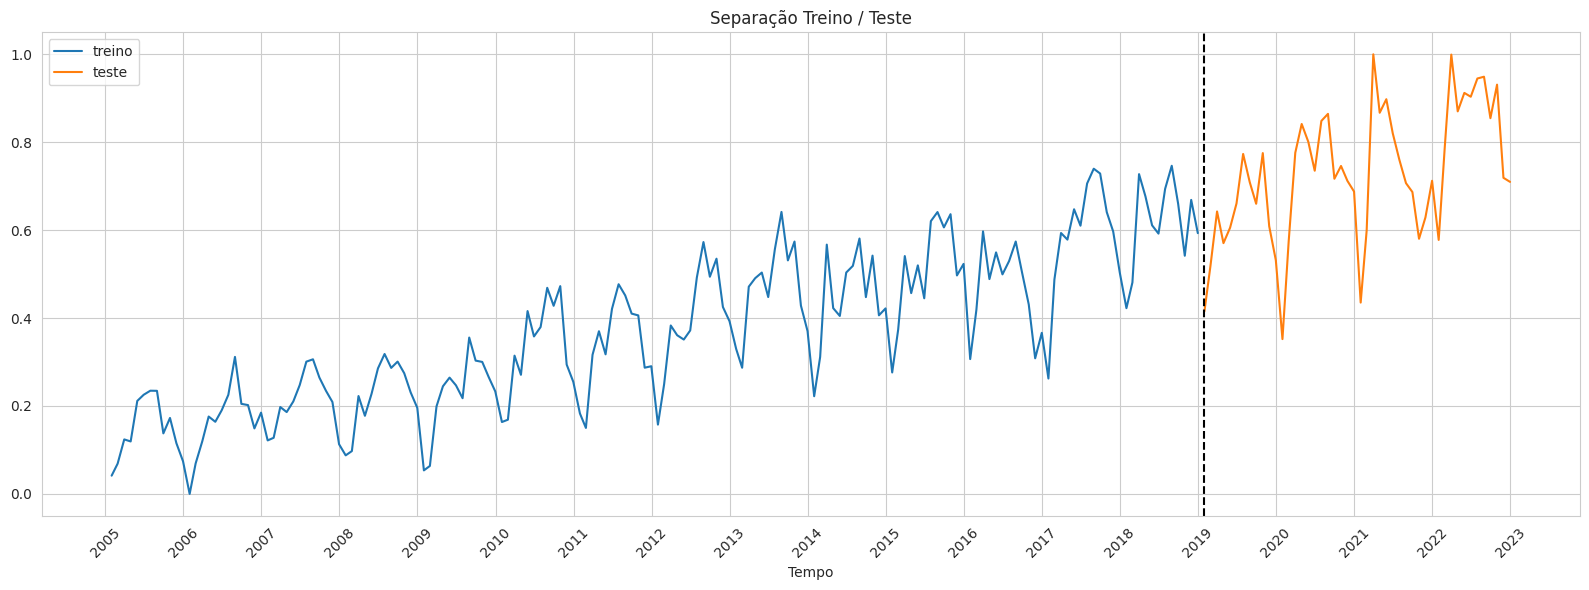

In [36]:
#Supondo que x_treino e x_teste sejam arrays de datas
fig, ax = plt.subplots(figsize=(16,6))
sns.set_style('whitegrid')
sns.lineplot(x=d_treino, y=y_treino, label='treino', ax=ax)
sns.lineplot(x=d_teste, y=y_teste, label='teste', ax=ax)

# Adicionando linha de separação entre treino e teste
ax.axvline(x=d_teste[0], linestyle='--', label='Início do teste', color='k')

# Configurando formatação do eixo x para datas mensais
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1]))

# Rotacionando os rótulos do eixo x
plt.xticks(rotation=45)

# Definindo títulos e rótulos
ax.set(title='Separação Treino / Teste', xlabel='Tempo', ylabel='')

plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

# Modelo Prophet - biblioteca oficial

In [37]:
# Renomear as colunas para o formato esperado pelo Prophet
original = original.rename(columns={'data': 'ds', 'porto': 'y'})

In [38]:
# Criar e ajustar o modelo Prophet
model = Prophet()
model.fit(original)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp25edugnl/nsb3h7q_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp25edugnl/y0mtr4d1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12387', 'data', 'file=/tmp/tmp25edugnl/nsb3h7q_.json', 'init=/tmp/tmp25edugnl/y0mtr4d1.json', 'output', 'file=/tmp/tmp25edugnl/prophet_modelz7jlsxv3/prophet_model-20240613013452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:34:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:34:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [39]:
# Criar um dataframe para prever os próximos meses de 2023
# Adicionamos períodos adicionais ao final do dataframe original
future = model.make_future_dataframe(periods=12, freq='M')


In [40]:
# Fazer previsões
forecast = model.predict(future)


In [51]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2005-01-01,5.739781e+06,3.110894e+06,4.774039e+06,5.739781e+06,5.739781e+06,-1.827312e+06,-1.827312e+06,-1.827312e+06,-1.827312e+06,-1.827312e+06,-1.827312e+06,0.0,0.0,0.0,3.912469e+06
1,2005-02-01,5.769143e+06,3.778263e+06,5.452831e+06,5.769143e+06,5.769143e+06,-1.151190e+06,-1.151190e+06,-1.151190e+06,-1.151190e+06,-1.151190e+06,-1.151190e+06,0.0,0.0,0.0,4.617953e+06
2,2005-03-01,5.801651e+06,5.495550e+06,7.186330e+06,5.801651e+06,5.801651e+06,5.811034e+05,5.811034e+05,5.811034e+05,5.811034e+05,5.811034e+05,5.811034e+05,0.0,0.0,0.0,6.382754e+06
3,2005-04-01,5.833110e+06,5.223260e+06,6.898945e+06,5.833110e+06,5.833110e+06,2.124756e+05,2.124756e+05,2.124756e+05,2.124756e+05,2.124756e+05,2.124756e+05,0.0,0.0,0.0,6.045585e+06
4,2005-05-01,5.865617e+06,5.461805e+06,7.158760e+06,5.865617e+06,5.865617e+06,4.609034e+05,4.609034e+05,4.609034e+05,4.609034e+05,4.609034e+05,4.609034e+05,0.0,0.0,0.0,6.326521e+06


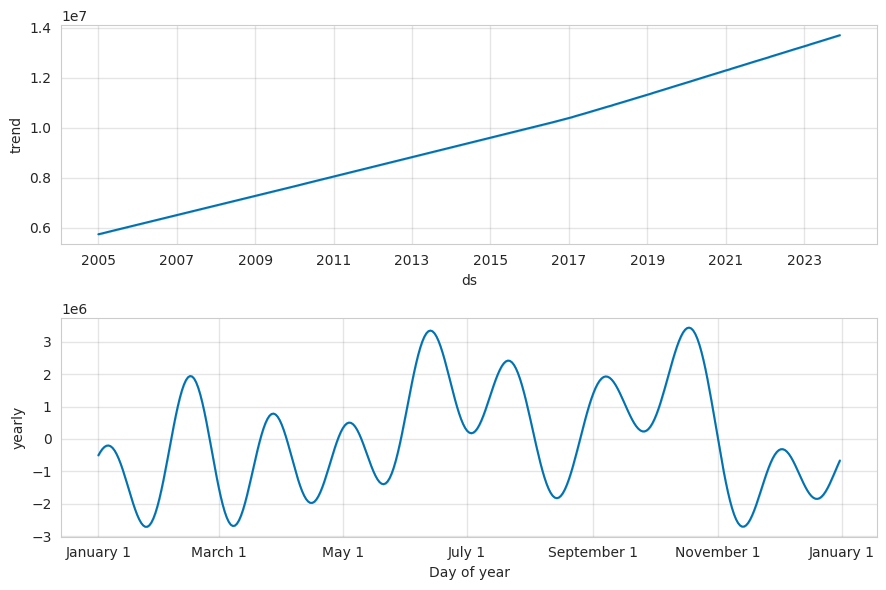

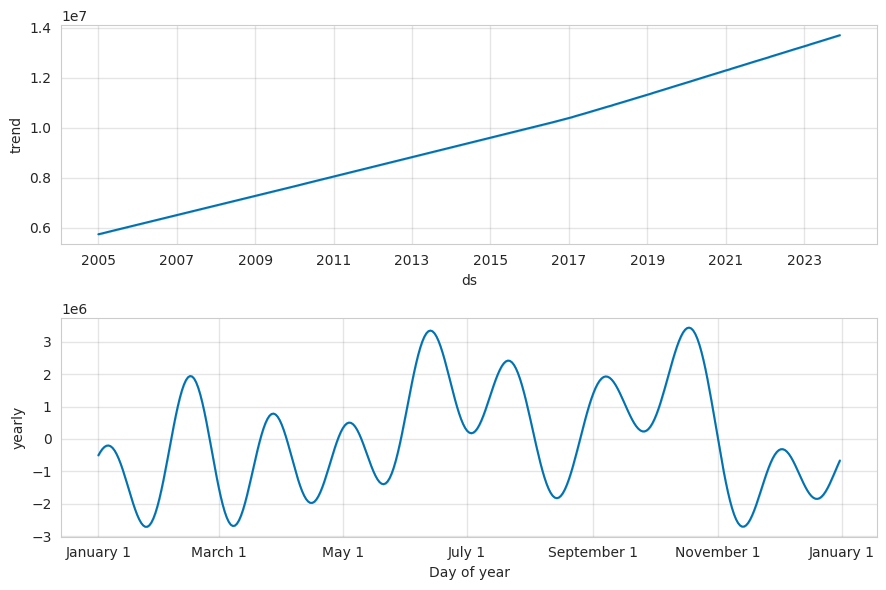

In [57]:
# Plot the components
model.plot_components(forecast)

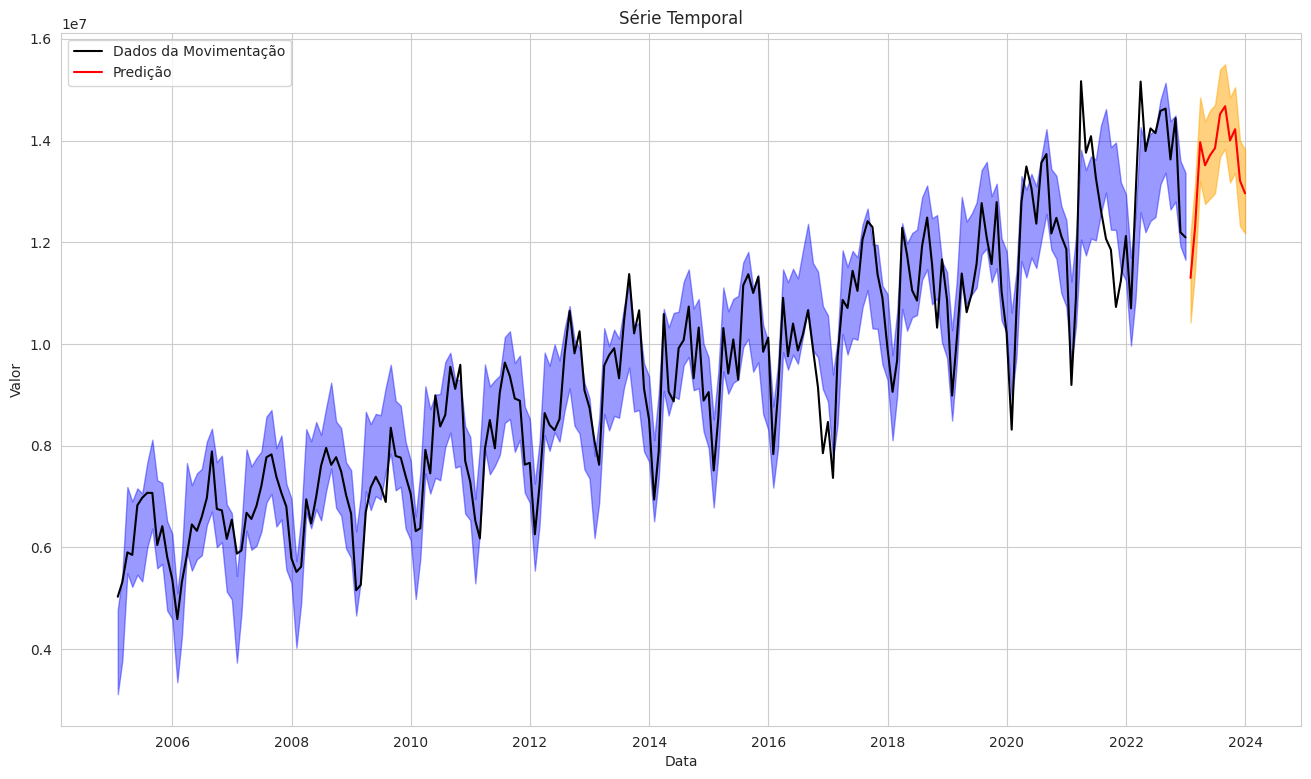

In [42]:
# Visualizar as previsões
plt.figure(figsize=(16, 9))

# Plotar a série temporal original
plt.plot(original['ds'], original['y'], label='Dados da Movimentação', color='k')

# Plotar as previsões
plt.plot(forecast['ds'][216:], forecast['yhat'][216:], label='Predição', color='red')

# Adicionar intervalos de confiança
#plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='cyan', alpha=0.2)
plt.fill_between(forecast['ds'][:216], forecast['yhat_lower'][:216], forecast['yhat_upper'][:216], color='blue', alpha=0.4)
plt.fill_between(forecast['ds'][216:], forecast['yhat_lower'][216:], forecast['yhat_upper'][216:], color='orange', alpha=0.5)

# Adicionar títulos e legendas
plt.title('Série Temporal')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()

# Mostrar o gráfico
plt.show()

In [43]:
# Exibir parâmetros do modelo
print("Parametros do modelo:")
print(model.seasonalities)
print("\nChangepoints detectados pelo modelo:")
print(model.changepoints)
print("\nOutros parâmetros ajustados:")
print(model.params)

Parametros do modelo:
OrderedDict([('yearly', {'period': 365.25, 'fourier_order': 10, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None})])

Changepoints detectados pelo modelo:
7     2005-08-31
14    2006-03-31
21    2006-10-31
27    2007-04-30
34    2007-11-30
41    2008-06-30
48    2009-01-31
55    2009-08-31
62    2010-03-31
68    2010-09-30
75    2011-04-30
82    2011-11-30
89    2012-06-30
96    2013-01-31
103   2013-08-31
109   2014-02-28
116   2014-09-30
123   2015-04-30
130   2015-11-30
137   2016-06-30
144   2017-01-31
150   2017-07-31
157   2018-02-28
164   2018-09-30
171   2019-04-30
Name: ds, dtype: datetime64[ns]

Outros parâmetros ajustados:
OrderedDict([('lp__', array([[565.727]])), ('k', array([[0.452413]])), ('m', array([[0.378467]])), ('delta', array([[ 5.93781e-09, -9.32317e-10,  8.51679e-08,  6.92310e-09,
         2.36575e-07,  3.21146e-04,  4.54229e-03,  1.68100e-07,
        -1.52352e-09, -8.05161e-10,  1.51060e-09, -6.19214e-10,
        -6.21774e-09

In [44]:
# Salvar as previsões em um arquivo CSV, se desejar
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('/content/drive/MyDrive/Colab Notebooks/PI5/staging/previsoes_2023.csv', index=False)


In [45]:
forecast.ds = forecast.ds.apply(lambda x: x.replace(day=1))
forecast.ds.tail()

223   2023-08-01
224   2023-09-01
225   2023-10-01
226   2023-11-01
227   2023-12-01
Name: ds, dtype: datetime64[ns]

# Comparando os dados de 2023 Previstos x Realizados

In [46]:
posterior_df = pd.read_csv('./staging/posterior_ts.csv')
posterior_df.data = pd.to_datetime(posterior_df.data)

In [47]:
linear_df = pd.read_csv('./staging/linear_reg.csv')
linear_df['data'] = pd.to_datetime(linear_df['data'])

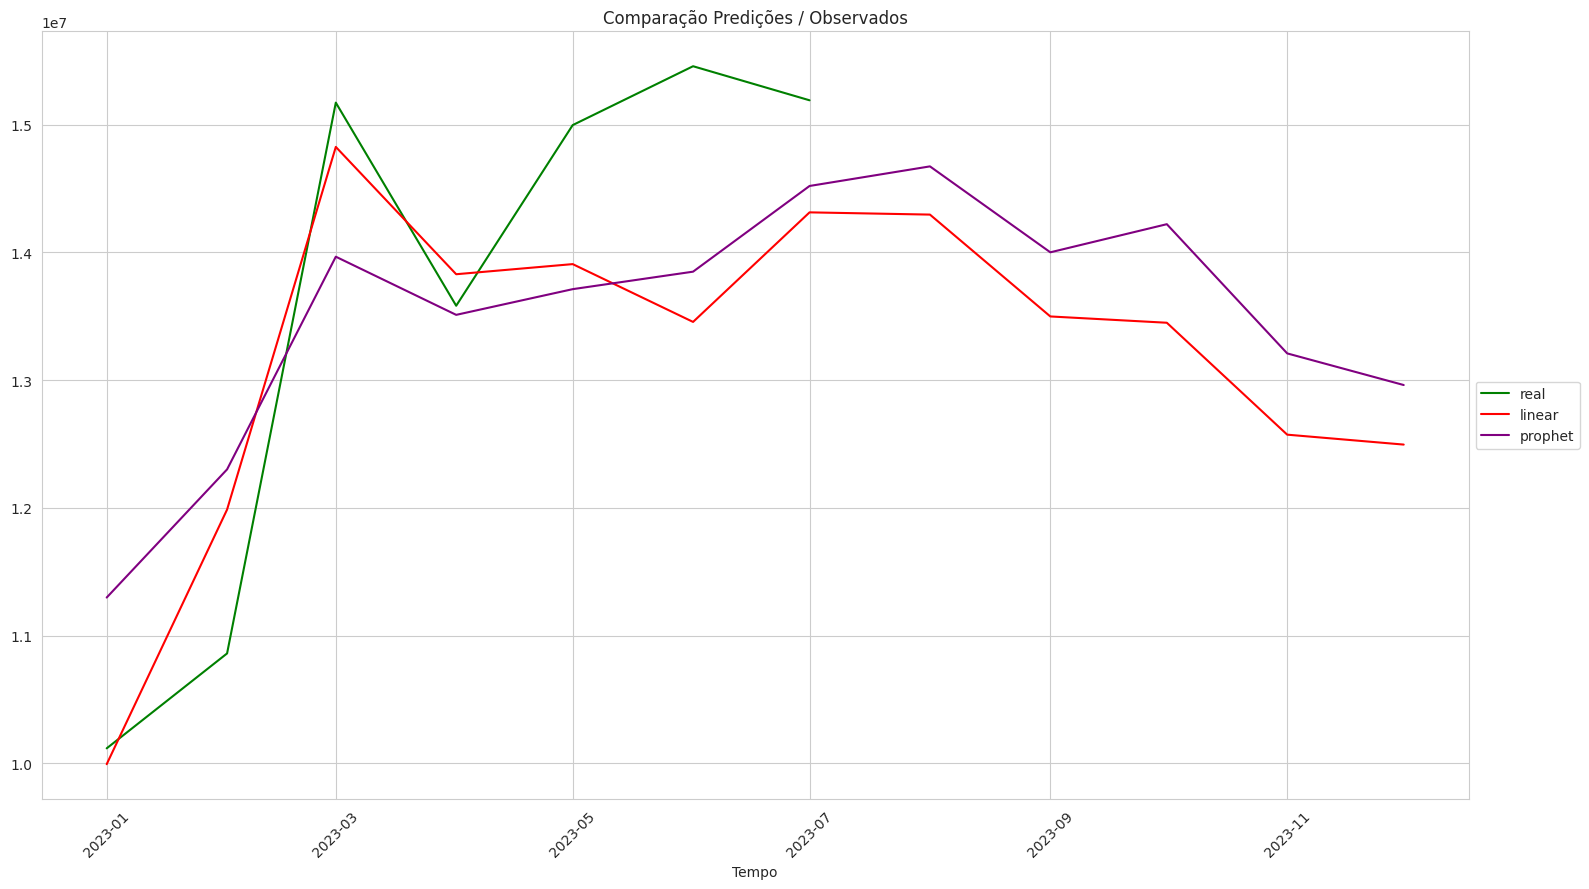

In [48]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(16,9))

sns.lineplot(x=posterior_df.data, y=posterior_df.porto, label='real', ax=ax, color='g')
sns.lineplot(x=linear_df.data, y=linear_df.porto, label='linear', ax=ax, color='r')
sns.lineplot(x=forecast.ds[216:], y=forecast.yhat[216:], label='prophet', ax=ax, color='purple')

# Configurando formatação do eixo x para datas mensais
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotacionando os rótulos do eixo x
plt.xticks(rotation=45)

# Configurando a legenda
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Definindo títulos e rótulos
ax.set(title='Comparação Predições / Observados', xlabel='Tempo', ylabel='')

plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

# Comparação dos Modelos

In [49]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))


y_real = posterior_df.porto
y_linear = linear_df.porto[0:7]
y_pht = forecast.yhat[215:215+7].tolist()
print('Erro do Modelo Linear')
print("RMSE:", rmse(y_real, y_linear))
print("MAE:", mae(y_real, y_linear))
print('\nErro do Modelo Prophet Original')
print("RMSE:", rmse(y_real, y_pht))
print("MAE:", mae(y_real, y_pht))


Erro do Modelo Linear
RMSE: 1030378.989730963
MAE: 830471.2857142857

Erro do Modelo Prophet Original
RMSE: 1748124.48727395
MAE: 1523575.2749507339
